# Process Stations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename

from climpyrical.gridding import scale_model_obs
from climpyrical.data import read_data
from climpyrical.cmd.find_matched_model_vals import add_model_values

### Load station data for processing

In [2]:
# parameter cell
# these currently have default values but are configurable when 
# executing this notebook with papermill

station_dv = "RL50 (kPa)"
station_input_path = resource_filename("climpyrical", "data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv")
name = "RL50"
processed_model_output_path = resource_filename("climpyrical", "data/results/intermediate/default.nc")
df_path_write = resource_filename('climpyrical', f'data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv')

In [3]:
# Parameters
station_dv = "RL50 (kPa)"
station_input_path = "/home/nannau/11202020/climpyrical/climpyrical/data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv"
filename = "RL50"
processed_model_output_path = "/home/nannau/11202020/climpyrical/climpyrical/data/results/intermediate/preprocessed_models/RL50_preprocessed.nc"
df_path_write = "/home/nannau/11202020/climpyrical/climpyrical/data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv"


In [4]:
df = pd.read_csv(station_input_path, index_col=None)

def check_df_columns(df):
    if 'longitude' in df.columns:
        df=df.rename(columns={'longitude': 'lon'})
    if 'long' in df.columns:
        df=df.rename(columns={'long': 'lon'})
    if 'latitude' in df.columns:
        df=df.rename(columns={'latitude': 'lat'})
    if 'name' in df.columns:
        df=df.rename(columns={'name': 'station_name'})
    if 'Name' in df.columns:
        df=df.rename(columns={'Name': 'station_name'})
    return df

df = check_df_columns(df)
df.head(5)

,id,station_name,province,lon,lat,elev (m),SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,BC,-123.742,48.9350,75,2.2,0.794
1,78,SAANICHTON CDA,BC,-123.419,48.6217,61,1.4,0.594
2,91,SHAWNIGAN LAKE,BC,-123.626,48.6469,159,2.4,0.818
3,109,VICTORIA GONZALES HTS,BC,-123.325,48.4131,70,1.3,0.387
4,149,ALERT BAY,BC,-126.933,50.5833,59,1.6,0.587


In [5]:
# transform into rotated pole and assign as new columns

# Create array of mean
if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("Temperature DV detected in degC. Converitng to Kelvin")
    K = 273.15 # K
    df[station_dv] += K
else:
    print("Not a temperature field. No unit conversion.")
    df[station_dv] = df[station_dv].values

if 'RL50 (kPa)' in station_dv:
    df = df[df[station_dv] != 0.0]

Not a temperature field. No unit conversion.


### Open the pre-processed model from the previous step

In [6]:
pre_processed_path = resource_filename(
    "climpyrical",
    f"/data/results/intermediate/preprocessed_models/{name}_preprocessed.nc"
)
print(pre_processed_path)
ds = read_data(pre_processed_path)
(dv, ) = ds.data_vars
df = add_model_values(pre_processed_path, df=df)
df.head(5)

INFO:root:Detect units: kPas


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


/home/nannau/11202020/climpyrical/climpyrical/data/results/intermediate/preprocessed_models/RL50_preprocessed.nc


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


,id,station_name,province,lon,lat,elev (m),SL50 (kPa),RL50 (kPa),rlat,rlon,irlat,irlon,model_values
0,15,CHEMAINUS,BC,-123.742,48.9350,75,2.2,0.794,4.407283,-17.245771,754,385,0.487415
1,78,SAANICHTON CDA,BC,-123.419,48.6217,61,1.4,0.594,4.041212,-17.148280,746,387,0.348818
2,91,SHAWNIGAN LAKE,BC,-123.626,48.6469,159,2.4,0.818,4.110152,-17.269400,747,384,0.490485
3,109,VICTORIA GONZALES HTS,BC,-123.325,48.4131,70,1.3,0.387,3.823732,-17.157965,741,387,0.330530
4,149,ALERT BAY,BC,-126.933,50.5833,59,1.6,0.587,6.674747,-18.602266,805,354,0.567683


### Group stations that land in the same index in rlat and rlon
This means that they are in the same grid cell and need to be aggregated

In [7]:
df_match = df.groupby(['irlat', 'irlon'], as_index=False).mean()


irlat = df_match.irlat
irlon = df_match.irlon

Identify locations where the closest grid cell falls on a invalid model value

Text(0, 0.5, 'Model')

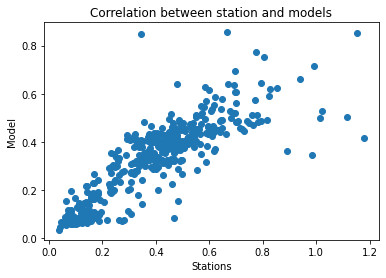

In [8]:
plt.scatter(df_match[station_dv], df_match.model_values)
plt.title("Correlation between station and models")
plt.xlabel('Stations')
plt.ylabel('Model')

Now each station should be matched with a value grid cell value

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that
$$\mu_s - \frac{\mu_m}{\beta} \approx 0$$ where $\mu_s$ is the spatial station mean and $\mu_m$ is the spatial model mean. 

In [9]:
# calculate ratios with applied correction
ratio, best_tol = scale_model_obs(df_match.model_values, df_match[station_dv])
assert not np.any(np.isnan(ratio))
df_match = df_match.assign(ratio=ratio)
print("Scaling factor:", best_tol)

Scaling factor: 0.8387427753361661


In [10]:
df_match.head(3)

,irlat,irlon,id,lon,lat,elev (m),SL50 (kPa),RL50 (kPa),rlat,rlon,model_values,ratio
0,558,1009,6038.0,-82.9556,42.2756,190.0,1.0,0.402,-4.286849,10.373390,0.285755,1.179944
1,559,1009,6037.0,-82.9333,42.3333,188.0,1.2,0.484,-4.227125,10.379271,0.286351,1.417673
2,576,1017,5880.0,-82.3047,42.9922,181.0,1.5,0.389,-3.494586,10.713492,0.286172,1.140122


In [11]:
df_match.to_csv(df_path_write, index=False)

In [12]:
assert np.all(df_match['ratio'] >= 0)